In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helium

plotdir = '../../cvxportfolio/portfolio/plots/'
datadir='../../cvxportfolio/data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers = ['AMZN', 'GOOGL', 'BAC', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

start_date="2012-02-01"
end_date="2014-02-08"

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [3]:
cash_ticker = "_CASH"

In [4]:
sigmas[cash_ticker] = 0.
returns = returns.rename(columns={"USDOLLAR": cash_ticker})
volumes[cash_ticker] = np.finfo(np.float).max

In [5]:
w_b = pd.Series(index=returns.columns, data=1)
w_b._CASH = 0.
w_b/=sum(w_b)


In [6]:
return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()

return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [7]:
sigma_estimate[cash_ticker] = 0.
return_estimate = return_estimate.rename(columns={"USDOLLAR": cash_ticker})
volume_estimate[cash_ticker] = np.finfo(np.float).max

In [8]:
borrow_costs = returns.copy()
borrow_costs[:] = 1E-4
borrow_costs[cash_ticker] = 0.

dividends = returns.copy()
dividends[:] = 0.

simulated_hcost=helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
simulated_tcost=helium.TransactionCost(gamma =1.0, 
                                             half_spread=0.0005/2,
                                             nonlin_coef = 1.,
                                             sigmas = sigmas, 
                                             nonlin_power = 1.5,
                                             volumes = volumes,
                                             asym_coef = 0.)

simulator = helium.MarketSimulator(returns, volumes, costs=[
    simulated_tcost, 
    simulated_hcost
], cash_ticker=cash_ticker)

In [9]:
r_est_dict = {}
d_est_dict = {}
for day in return_estimate.index[:-1]:
    rrr = return_estimate.loc[day:].iloc[:2].copy()
    r_est_dict[day] = rrr
    deltas = rrr.copy()
    deltas[:] = 0.
    d_est_dict[day] = deltas

In [10]:
r= helium.DefaultRet(r_est_dict,  d_est_dict , gamma_decay=None)
#Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

In [11]:
Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

In [12]:
policies = {}
results = {}
gamma_risks_coarse=[.1,.3,1, 3,10,30,100,300,1000]
gamma_tcosts_coarse=[1., 2., 5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse: 
        print(gamma_risk, gamma_tcost)
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [
           
            risk_model, 
                 optimization_tcost, 
                optimization_hcost
                ]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.MultiPeriodOpt(r, costs, const, 2)
        results[(gamma_risk, gamma_tcost)] = simulator.run(1E8*w_b, 
                                                         policies[(gamma_risk, gamma_tcost)],
                                                         start_date, 
                                                         end_date)

0.1 1.0
0.1 2.0
0.1 5
0.1 10
0.1 20
0.3 1.0
0.3 2.0
0.3 5
0.3 10
0.3 20
1 1.0
1 2.0
1 5
1 10
1 20
3 1.0
3 2.0
3 5
3 10
3 20
10 1.0
10 2.0
10 5
10 10
10 20
30 1.0
30 2.0
30 5
30 10
30 20
100 1.0
100 2.0
100 5
100 10
100 20
300 1.0
300 2.0
300 5
300 10
300 20
1000 1.0
1000 2.0
1000 5
1000 10
1000 20


In [13]:
result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

[38.955876925159671, 38.217142298600869, 35.592408217920827, 26.861065625517959, 14.516285372344592, 6.3975890419082644, 2.4279372528312373, 0.97868995849070783, 0.37117221433639519] [39.56561117436772, 38.681603354244906, 37.9359430409689, 30.007808704139883, 18.0572136740183, 9.970579255942376, 4.4678058502364095, 1.8884528659101705, 0.6225980957407292]
[38.728776646003247, 36.820595901066675, 29.852369581152214, 20.844540385566397, 11.126340082497945, 4.7767003976656079, 1.8193700318383403, 0.76096638988208987, 0.31949199016374402] [43.199323349439865, 41.51901421102766, 35.97169378374385, 27.06041967516589, 15.311033894054662, 8.424591327917035, 3.6826360621094705, 1.534541504382709, 0.5043819544634792]
[31.538788213770609, 27.414743920020769, 21.40812038676129, 12.252217273042282, 6.0761992220802457, 3.0089089307826775, 1.2505558859486789, 0.54904099618297042, 0.26354806632020444] [27.201858382894073, 22.13082384445928, 16.348463367090726, 11.512472250583556, 8.080636583087683, 4.

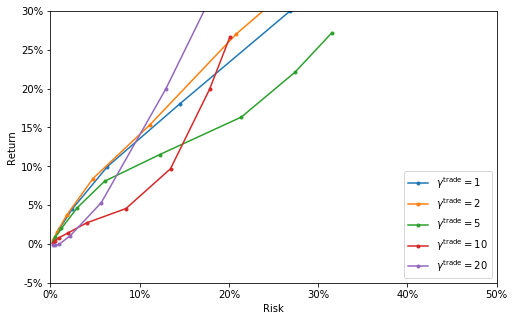

In [14]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,50])
plt.ylim([-5,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

### Fine Search

In [15]:
gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine:
        print(gamma_risk, gamma_tcost)
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [
           
            risk_model, 
                 optimization_tcost, 
                optimization_hcost
                ]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.MultiPeriodOpt(r, costs, const, 2)
        results[(gamma_risk, gamma_tcost)] = simulator.run(1E8*w_b, 
                                                         policies[(gamma_risk, gamma_tcost)],
                                                         start_date, 
                                                         end_date)

0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
1 4
1 5
1 6
1 7
1 8
3 4
3 5
3 6
3 7
3 8
10 4
10 5
10 6
10 7
10 8
30 4
30 5
30 6
30 7
30 8
100 4
100 5
100 6
100 7
100 8
300 4
300 5
300 6
300 7
300 8
1000 4
1000 5
1000 6
1000 7
1000 8


In [16]:
result_df_fine=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_fine and k[1] in list(gamma_tcosts_fine):
        result_df_fine.loc[k[0], k[1]] = results[k]
        
result_df_fine=result_df_fine.loc[sorted(result_df_fine.index),sorted(result_df_fine.columns)]

[30.693232616867629, 27.74545598206031, 21.789750826035046, 14.024020263388513, 7.2547132997769816, 3.4299138377534164, 1.3677461746418014, 0.58754426009607019, 0.27218255779610967] [29.05593840150604, 23.643271619402697, 17.325758790876318, 14.584256404536463, 10.553842383784847, 5.540273421755626, 2.441990717309359, 1.0601827654511538, 0.34211025836967696]
[31.538788202933546, 27.414743907872417, 21.408120387539224, 12.252217273299975, 6.0761992209350231, 3.008908930605291, 1.2505558791830393, 0.54904100457921967, 0.26354806801166036] [27.201858348091147, 22.13082383833096, 16.348463356160796, 11.512472255875839, 8.080636579359217, 4.661378390594018, 2.011593105458864, 0.8782669060455464, 0.2805212115778987]
[32.20637873709579, 27.991120477032414, 20.183253679790429, 11.175352793232781, 5.2638932979572148, 2.6638813288308469, 1.1585667505561825, 0.52455728351815922, 0.25934043977367532] [26.999008579681124, 22.095407550170368, 13.043585550252528, 8.479338534327622, 6.113186132829141,

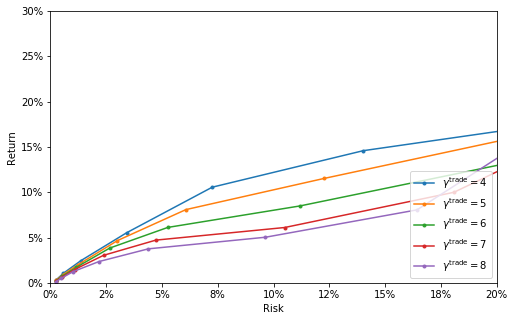

In [17]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df_fine.columns[:]:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_fine[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df_fine[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

### Pareto

In [ ]:
results_pareto={}

In [ ]:
policies = {}
#results = {}
gamma_risks_pareto=[0.1, 0.17782, 0.31624, 0.562, 1.0, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[5.5,6,6.5,7,7.5,8]
gamma_holdings=[.1,1.,10.,100.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
            optimization_hcost = helium.HoldingCost(gamma_holding , borrow_costs=borrow_costs, dividends=dividends)
            optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
            # issue optimization_tcost

            costs = [risk_model,    optimization_tcost,                  optimization_hcost  ]
            const = [helium.LeverageLimitConstraint(3)]
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = helium.MultiPeriodOpt(r, costs, const, steps=1)
            results_pareto[(gamma_risk, gamma_tcost, gamma_holding)] = simulator.run(1E8*w_b, 
                                                         policies[(gamma_risk, gamma_tcost, gamma_holding)],
                                                         start_date, 
                                                         end_date)

In [ ]:
len(results_pareto)

In [ ]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]
table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
#table.to_csv(datadir+'spo_pareto_results.csv', float_format='%g')

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_pareto.png')

In [ ]:
xlim=20
ylim=30
table=table[table.is_pareto]
table=table[table.Risk <= xlim]
table=table[table.Return <= ylim]
del table['is_pareto']
table.Risk=table.Risk.apply(lambda x: '%.2f%%'%x)
table.Return=table.Return.apply(lambda x: '%.2f%%'%x)
print(table.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

In [ ]:
table.tail(50)